In [53]:
import os

import numpy as np
import pandas as pd

import pcl
import pcl.pcl_visualization
import pythreejs
import pyntcloud
import matplotlib.pyplot as plt
import pcl_processing
from importlib import reload  

In [143]:
scan = np.fromfile('is_dataset/sequences/00/velodyne/000001.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile('is_dataset/sequences/00/labels/000001.label', dtype=np.uint32)
label = label.reshape((-1))

cloud_XYZ = pcl.PointCloud()
cloud_XYZ.from_array(scan[:,:3])

In [61]:
obstacle_lst = {
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [113]:
def roi_filter(pcloud, verbose=True, **params):
    if verbose:
        print('Input pcloud size: {}'.format(len(pcloud)))
    pcloud['camera'] = ((pcloud['x'] > params['min_x']) & (pcloud['x'] < params['max_x']) &
                       (pcloud['y'] >  params['min_y']) & (pcloud['y'] < params['max_y']) &
                       (pcloud['z'] >  params['min_z']) & (pcloud['z'] <  params['max_z']))
    pcloud = pcloud[pcloud['camera'] == True]
    pcloud = pcloud.drop(['camera'], axis=1)
    if verbose:
        print('Output ROI pcloud size: {}'.format(len(pcloud)))
    return pcloud

# pcloud = roi_filter(pcloud, min_x=-6, max_x=50, 
#                   min_y=-20, max_y=25, 
#                   min_z=-2, max_z=2)

In [5]:
pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                      columns=['x', 'y', 'z', 'seg_id'])
pcloud.seg_id = pcloud.seg_id.astype('uint32')
pcloud.seg_id = pcloud.seg_id.apply(lambda x: x & 0xFFFF)
pcloud = pcloud[pcloud['seg_id'].isin(list(obstacle_lst.keys()))]
pcloud_to_pcl = pcloud.drop(['seg_id'], axis=1)
print(pcloud_to_pcl.shape)
pcloud_pcl = pcl.PointCloud()
pcloud_pcl.from_array(pcloud_to_pcl.to_numpy(dtype=np.float32))

# сколько в метрах?, перебрать параметры по X
pcloud_pcl_roi = pcl_processing.roi_filter(pcloud_pcl, [-30, 30], [-6, 8], [-3, 3])

pcloud_pcl_roi_array = np.array(pcloud_pcl_roi, dtype=np.float32)
print(pcloud_pcl_roi_array.shape)

pcloud_pcl_fil = pcloud_pcl_roi.make_statistical_outlier_filter()
pcloud_pcl_fil.set_mean_k(50)
pcloud_pcl_fil.set_std_dev_mul_thresh(1.0)
pcloud_array = np.array(pcloud_pcl_fil.filter(), dtype=np.float32)
print(pcloud_array.shape)

#temp_cloud = pcloud[pcloud.seg_id == 10]
#temp_cloud = temp_cloud.drop(['seg_id'], axis=1)

(4797, 3)
(3405, 3)
(3064, 3)


In [180]:
from datetime import datetime
import time
from importlib import reload  

pcl_processing = reload(pcl_processing)

def pipeline_optimized(scan, label, obstacle_lst, n_voxels=40, verbose=False):
    
    # get segment id
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                          columns=['x', 'y', 'z', 'seg_id'])
    pcloud.seg_id = pcloud.seg_id.astype('uint32')
    pcloud.seg_id = pcloud.seg_id.apply(lambda x: x & 0xFFFF)
    print('*** GET SEGMENTS: ',datetime.now() - start_time)

    start_time = datetime.now()
    pcloud = roi_filter(pcloud, min_x=-6, max_x=40, 
                        min_y=-20, max_y=25, 
                        min_z=-2, max_z=2)
    
    print("*** roi filtering TIME: {}".format(datetime.now() - start_time))

    # filter chosen segments
    start_time = datetime.now()
    if verbose:
        print('filter needed segments')
    pcloud = pcloud[pcloud['seg_id'].isin(list(obstacle_lst.keys()))]
    print('*** filtering: ',datetime.now() - start_time)

    # get voxel grid
    
    #if verbose:
    #    print('get voxel grid')

    bboxes = []
    for seg in list(pcloud.seg_id.unique()):
        start_time = datetime.now()
        temp_cloud = pcloud[pcloud.seg_id == seg]
        print("segment: {}, shape: {}".format(obstacle_lst[seg], len(temp_cloud)))
        temp_cloud = temp_cloud.drop(['seg_id'], axis=1)
        #print(temp_cloud.dtypes)
        pcloud_pcl = pcl.PointCloud()
        pcloud_pcl.from_array(temp_cloud.to_numpy(dtype=np.float32))

        cluster_indices = pcl_processing.clustering(pcloud_pcl, 0.7, 50, 2000)        
        #TODO outlier filter
        print('*** clustering: ',datetime.now() - start_time)

        start_time = datetime.now()

        cloud_cluster_list, box_coord_list = pcl_processing.get_cluster_box_list(cluster_indices, pcloud_pcl, 
                                                                                radius_search=1, min_neighbors_in_radius=20)

        bboxes += box_coord_list
        #print(bboxes)
        print('*** bboxes: ',datetime.now() - start_time)
    return bboxes, pcloud

In [181]:
%time bboxes, pcloud_pcl = pipeline_optimized(scan, label, obstacle_lst)

*** GET SEGMENTS:  0:00:00.531106
Input pcloud size: 124605
Output ROI pcloud size: 88257
*** roi filtering TIME: 0:00:00.054020
*** filtering:  0:00:00.009295
segment: car, shape: 3380
*** clustering:  0:00:00.402323
*** bboxes:  0:00:00.851362
segment: moving-motorcyclist, shape: 73
*** clustering:  0:00:00.011943
*** bboxes:  0:00:00.004841
CPU times: user 1.56 s, sys: 263 ms, total: 1.82 s
Wall time: 1.88 s


<IPython.core.display.Javascript object>


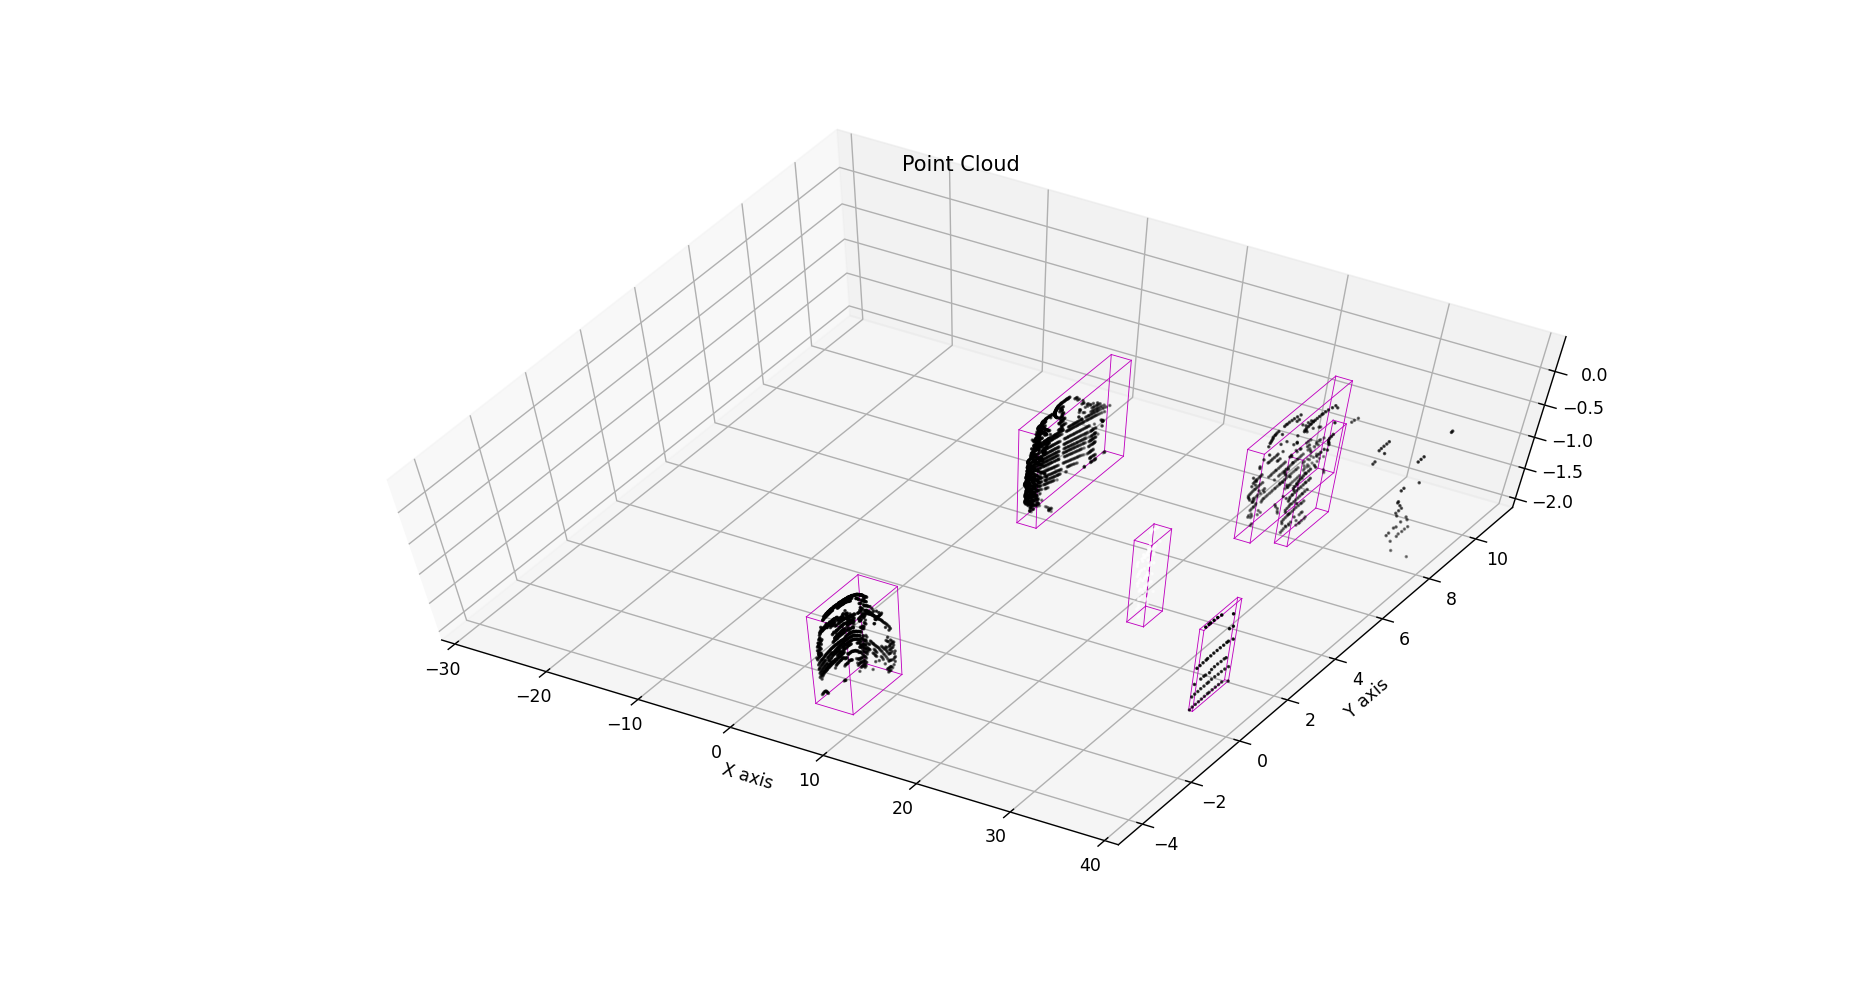

In [182]:
%matplotlib notebook
f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111, projection='3d')
# ax = f.add_subplot(111) 
pcl_processing.draw_point_cloud(pcloud_pcl, ax, 'Point Cloud', xlim3d=(-30,40))
for box in bboxes:
    pcl_processing.draw_box(ax, box, axes=[0, 1, 2], color='m')
plt.show()

In [81]:
scan1 = scan[:,:3]
test_cloud = pyntcloud.PyntCloud(pcloud_pcl)
test_cloud.plot(backend='pythreejs', use_as_color='seg_id')

/opt/conda/lib/python3.7/site-packages/pythreejs/traits.py:191: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.6519368392810571, 11.051446094267941, -0.…